<a href="https://colab.research.google.com/github/Jacob-Francis/SWSG_repo/blob/main/Colab_nb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from matplotlib.animation import FuncAnimation

In [14]:
from scipy import optimize
import numpy as np
import matplotlib.pyplot as plt
import torch
from scipy.spatial.distance import cdist as scipy_cdist
from plotting_utils import colour_bar
from functools import partial
import pickle
from unbalancedsinkhorn import UnbalancedOT, DebiasedUOT

# My python classes for loops we've defined so far
from swsg_ot_algorithm import SWSGSinkNewton, SWSGDynamcis
from scipy.special import lambertw as lambertw_scipy
from lambertw import halley_lambertw
from lambertw import _residual as _lambw_res
from geomloss import SamplesLoss

# pylint: disable=E1101
def incline(epsilon, f=1.0, g=0.1, a=0.2, b=1.0, c=0.5, d=1.0):
    """
    Initialise a jet profile and associated object for solving the sWSG problem.
    """
    global n1, n2, m1, m2

    # Assigning uniform weighting to points - Lloyde type
    def height_func(x):
        return a * b * (x - c) + d

    # integral of tanh is ln(cosh) so;
    def int_h(x):
        return a * b * (x**2 / 2 - c * x) + d * x

    # find X_j s.t. universe weighting is 1/N
    # X_j = np.zeros(n1)
    # for k, ui in enumerate(
    #     d * np.linspace(1 / (2 * n1), 1 - 1 / (2 * n1), n1, endpoint=True)
    # ):
    #     X_j[k] = optimize.root(lambda x: int_h(x) - ui, x0=0).x[0]
    X_j = np.zeros(n1)
    for k, ui in enumerate(
        d*np.linspace(1 / n1, 1 , n1, endpoint=True)
    ):
        X_j[k] = optimize.root(lambda x: int_h(x) - ui, x0=0).x[0]

    X_j[1:] = (X_j[:-1] + X_j[1:]) / 2
    X_j[0] = X_j[0] / 2


    # Calculate nabla P: x + f^2 * g * partial h
    G_i = X_j + f**-2 * g * a * b

    # Tile the 1D into a 2D profile
    X = torch.cartesian_prod(
        torch.linspace(1 / (2 * m2), 1 - 1 / (2 * m2), m2),
        torch.linspace(1 / (2 * m1), 1 - 1 / (2 * m1), m1),
    )
    Y = torch.cartesian_prod(
        torch.linspace(1 / (2 * n2), 1 - 1 / (2 * n2), n2), torch.Tensor(X_j)
    )
    G = torch.cartesian_prod(
        torch.linspace(1 / (2 * n2), 1 - 1 / (2 * n2), n2), torch.Tensor(G_i)
    )
    h_true = height_func(X[:, 1]).view(-1, 1)
    mu = torch.ones_like(h_true) * d / len(X[:, 1])

    return X, Y, G, h_true, mu


def incline_no_llody(epsilon, f=1.0, g=0.1, a=0.2, b=1.0, c=0.5, d=1.0):
    """
    Initialise a jet profile and associated object for solving the sWSG problem.
    """
    global n1, n2, m1, m2

    # Assigning uniform weighting to points - Lloyde type
    def height_func(x):
        return a * b * (x - c) + d

    X_j = d * np.linspace(1 / (2 * n1), 1 - 1 / (2 * n1), n1, endpoint=True)

    # Calculate nabla P: x + f^2 * g * partial h
    G_i = X_j + f**-2 * g * a * b

    # Tile the 1D into a 2D profile
    X = torch.cartesian_prod(
        torch.linspace(1 / (2 * m2), 1 - 1 / (2 * m2), m2),
        torch.linspace(1 / (2 * m1), 1 - 1 / (2 * m1), m1),
    )
    Y = torch.cartesian_prod(
        torch.linspace(1 / (2 * n2), 1 - 1 / (2 * n2), n2), torch.Tensor(X_j)
    )
    G = torch.cartesian_prod(
        torch.linspace(1 / (2 * n2), 1 - 1 / (2 * n2), n2), torch.Tensor(G_i)
    )
    h_true = height_func(X[:, 1]).view(-1, 1)
    mu = h_true * d / h_true.sum()

    return X, Y, G, h_true, mu


def initialisation(
    epsilon=0.05, f=1.0, g=0.1, a=0.1, b=10.0, c=0.5, d=1.0, profile_type="jet", cuda=1
):
    """
    Initialise a jet profile and associated object for solving the sWSG problem.
    """
    # Decide on parameters
    global n1, n2, m1, m2
    n1, n2 = int(1 / epsilon), int(1 / epsilon)
    m1, m2 = int(1 / epsilon), int(1 / epsilon)

    if profile_type == "jet":
        # Assigning uniform weighting to points - Lloyde type
        def height_func(x):
            return a * np.tanh(b * (x - c)) + d

        # integral of tanh is ln(cosh) so;
        def int_h(x):
            return a * np.log(np.cosh(b * (x - 0.5)) / np.cosh(-b * 0.5)) / b + d * x

        # find X_j s.t. universe weighting is 1/N
        # X_j = np.zeros(n1)
        # for k, ui in enumerate(
        #     d * np.linspace(1 / (2 * n1), 1 - 1 / (2 * n1), n1, endpoint=True)
        # ):
        #     X_j[k] = optimize.root(lambda x: int_h(x) - ui, x0=0).x[0]
        X_j = np.zeros(n1)
        for k, ui in enumerate(
            d*np.linspace(1 / n1, 1 , n1, endpoint=True)
        ):
            X_j[k] = optimize.root(lambda x: int_h(x) - ui, x0=0).x[0]

        X_j[1:] = (X_j[:-1] + X_j[1:]) / 2
        X_j[0] = X_j[0] / 2

        # Calculate nabla P: x + f^2 * g * partial h
        G_i = X_j + f**2 * g * a * b * (1 - np.tanh(b * (X_j - 0.5)) ** 2)

        # Tile the 1D into a 2D profile
        X = torch.cartesian_prod(
            torch.linspace(1 / (2 * m2), 1 - 1 / (2 * m2), m2),
            torch.linspace(1 / (2 * m1), 1 - 1 / (2 * m1), m1),
        )
        Y = torch.cartesian_prod(
            torch.linspace(1 / (2 * n2), 1 - 1 / (2 * n2), n2), torch.Tensor(X_j)
        )
        G = torch.cartesian_prod(
            torch.linspace(1 / (2 * n2), 1 - 1 / (2 * n2), n2), torch.Tensor(G_i)
        )
        h_true = height_func(X[:, 1]).view(-1, 1)
        mu = torch.ones_like(h_true) * d / len(X[:, 1])
    elif profile_type == "jet_no_lloyd":
        # Assigning uniform weighting to points - Lloyde type
        def height_func(x):
            return a * np.tanh(b * (x - c)) + d

        X_j = d * np.linspace(1 / (2 * n1), 1 - 1 / (2 * n1), n1, endpoint=True)

        # Calculate nabla P: x + f^2 * g * partial h
        G_i = X_j + f**2 * g * a * b * (1 - np.tanh(b * (X_j - 0.5)) ** 2)

        # Tile the 1D into a 2D profile
        X = torch.cartesian_prod(
            torch.linspace(1 / (2 * m2), 1 - 1 / (2 * m2), m2),
            torch.linspace(1 / (2 * m1), 1 - 1 / (2 * m1), m1),
        )
        Y = torch.cartesian_prod(
            torch.linspace(1 / (2 * n2), 1 - 1 / (2 * n2), n2), torch.Tensor(X_j)
        )
        G = torch.cartesian_prod(
            torch.linspace(1 / (2 * n2), 1 - 1 / (2 * n2), n2), torch.Tensor(G_i)
        )
        h_true = height_func(X[:, 1]).view(-1, 1)
        mu = h_true * d / h_true.sum()

    elif profile_type == "uniform":
        X = torch.cartesian_prod(
            torch.linspace(1 / (2 * m2), 1 - 1 / (2 * m2), m2),
            torch.linspace(1 / (2 * m1), 1 - 1 / (2 * m1), m1),
        )
        Y = torch.cartesian_prod(
            torch.linspace(1 / (2 * n2), 1 - 1 / (2 * n2), n2),
            torch.linspace(1 / (2 * n1), 1 - 1 / (2 * n1), n1),
        )
        G = torch.cartesian_prod(
            torch.linspace(1 / (2 * n2), 1 - 1 / (2 * n2), n2),
            torch.linspace(1 / (2 * n1), 1 - 1 / (2 * n1), n1),
        )
        h_true = torch.ones_like(X[:, 1]).view(-1, 1)
        mu = torch.ones_like(h_true) * d / len(X[:, 1])
    elif profile_type == "incline":
        X, Y, G, h_true, mu = incline(epsilon, f=1.0, g=0.1, a=0.2, b=1.0, c=0.5, d=1.0)
    elif profile_type == "incline_no_lloyd":
        X, Y, G, h_true, mu = incline_no_llody(
            epsilon, f=1.0, g=0.1, a=0.2, b=1.0, c=0.5, d=1.0
        )

    if cuda is None:
        swsg_class = SWSGSinkNewton(pykeops=True, set_fail=True)
    else:
        swsg_class = SWSGSinkNewton(
            pykeops=True, set_fail=False, cuda_device=f"cuda:{cuda}"
        )
    # torch.cuda.set_device(5)
    swsg_class.parameters(ε=epsilon, f=f, g=g)
    swsg_class.densities(source_points=G, target_points=X, source_density=mu)

    # assert (swsg_class.β_t == mu).all()

    return X, Y, G, swsg_class, h_true


def torch_sum_exp(f, X, Y, α, ε):
    """
    Log-Sum-Exp torch implementation
    """
    return torch.sum(
        torch.exp((f.view(-1, 1) - 0.5 * torch.cdist(X, Y) ** 2) / ε) * α.view(-1, 1),
        dim=0,
    ).view(-1, 1)


def initialise_potentials(swsg_class):

    # psi = -ones(length(x(:)),1) ;
    # psiS = zeros(length(x(:)),1) ;
    # psi0S = zeros(length(x(:)),1) ;%% potentiel cote x
    # phi = zeros(length(X(:)),1) ;
    # psi0 = psi ;
    # phi0 = phi ;
    # phi0S = zeros(length(X(:)),1) ; %% potentiel cote  X  X va bouger ,,,,
    # phiS = zeros(length(X(:)),1) ; %% potentiel cote  X  X va bouger ,,,,

    # initialise the three potentials
    φ = 0.0 * torch.ones_like(swsg_class.α_s)
    ψ_s = torch.ones_like(swsg_class.β_t) * 0.0

    temp = swsg_class.pykeops_formulas.barycentres_bottom(
        φ,
        swsg_class.X_s,
        swsg_class.Y_t,
        swsg_class.epsilon,
        swsg_class.α_s,
        swsg_class.f_constant**2,
    )

    temp = (
        swsg_class.g_constant
        * torch.exp(ψ_s / swsg_class.epsilon)
        * temp
        / swsg_class.epsilon
    )

    ψ = torch.ones_like(swsg_class.β_t) * -1.0

    # k is the branch
    return φ, ψ, ψ_s


def torch_cdist_approach(swsg_class, lambert_tolerance=1e-12, tolerance=1e-12):
    """
    Torch implementation (not on the fly) of SWSG solver using JD's third debiased approach
    """

    φ, ψ, ψ_s = initialise_potentials(swsg_class)

    max_iterates = int(
        -1.1 / swsg_class.epsilon.cpu() * np.log(swsg_class.epsilon.cpu())
    )
    error_list = []

    for _ in range(max_iterates):
        # calculate psuedo error for ternimation:
        φ_temp, ψ_temp, ψ_s_temp = φ.clone(), ψ.clone(), ψ_s.clone()

        # update phi
        φ = -swsg_class.epsilon * torch.log(
            torch_sum_exp(
                ψ, swsg_class.Y_t, swsg_class.X_s, swsg_class.β_t, swsg_class.epsilon
            )
        )

        # print('k', φ.sum(), ψ.sum(), ψ_s.sum())

        # update psi
        temp = torch_sum_exp(
            φ, swsg_class.X_s, swsg_class.Y_t, swsg_class.α_s, swsg_class.epsilon
        )

        temp = (
            swsg_class.g_constant
            * torch.exp(ψ_s / swsg_class.epsilon)
            * temp
            / swsg_class.epsilon
        )

        ψ = (
            ψ_s - swsg_class.epsilon * lambertw(temp, k=0, tol=lambert_tolerance).real
        )  # k is the branch

        # update psi_s
        temp = torch_sum_exp(
            ψ_s, swsg_class.Y_t, swsg_class.Y_t, swsg_class.β_t, swsg_class.epsilon
        )

        temp = (
            swsg_class.g_constant
            * torch.exp(ψ / swsg_class.epsilon)
            * temp
            / swsg_class.epsilon
        )

        if (-temp < 0).all() or (temp > 1 / np.exp(1)).all():
            pass
        else:
            print("Domain issues")
            break

        ψ_s = (
            ψ - swsg_class.epsilon * lambertw(-temp, k=-1, tol=lambert_tolerance).real
        )  # k is the branch
        ψ_s = 0.5 * (ψ_s + ψ_s_temp)

        # calculate psuedo error for ternimation:
        error_list.append(
            max(
                torch.linalg.norm(φ_temp - φ, ord=float("inf")),
                torch.linalg.norm(ψ_temp - ψ, ord=float("inf")),
                torch.linalg.norm(ψ_s_temp - ψ_s, ord=float("inf")),
            ).item()
        )

        if error_list[-1] < tolerance or np.isnan(error_list[-1]):
            print("finished:", error_list[-5:], len(error_list))
            break

    return φ, ψ, ψ_s, error_list


def pykeops_approach_W0Wminus1_outof_class(
    swsg_class, lambert_tolerance=1e-12, tolerance=1e-12, branch=-1, sym_update=True
):

    # initialise
    max_iterates = int(
        -1.1 / swsg_class.epsilon.cpu() * np.log(swsg_class.epsilon.cpu())
    )
    error_list = []

    φ, ψ, ψ_s = initialise_potentials(swsg_class)

    for _ in range(max_iterates):
        # calculate psuedo error for ternimation:
        φ_temp, ψ_temp, ψ_s_temp = φ.clone(), ψ.clone(), ψ_s.clone()

        # update phi
        φ = -swsg_class.epsilon.view(-1, 1) * swsg_class.pykeops_formulas.log_sum_exp(
            ψ,
            φ * 0,
            swsg_class.X_s,
            swsg_class.Y_t,
            swsg_class.epsilon.view(-1, 1),
            swsg_class.β_t,
            swsg_class.cost_const,
        )
        test = -swsg_class.epsilon * torch.log(
            torch_sum_exp(
                ψ, swsg_class.Y_t, swsg_class.X_s, swsg_class.β_t, swsg_class.epsilon
            )
        )
        # print(test.shape, φ.shape, torch.norm(φ - test))

        # update psi
        temp = swsg_class.pykeops_formulas.barycentres_bottom(
            φ,
            swsg_class.X_s,
            swsg_class.Y_t,
            swsg_class.epsilon,
            swsg_class.α_s,
            swsg_class.f_constant**2,
        )
        temp = (
            swsg_class.g_constant
            * torch.exp(ψ_s / swsg_class.epsilon)
            * temp
            / swsg_class.epsilon
        )

        ψ = (
            ψ_s - swsg_class.epsilon * lambertw(temp, k=0, tol=lambert_tolerance).real
        )  # k is the branch

        temp = swsg_class.pykeops_formulas.barycentres_bottom(
            ψ_s,
            swsg_class.Y_t,
            swsg_class.Y_t,
            swsg_class.epsilon,
            swsg_class.β_t,
            swsg_class.f_constant**2,
        )
        temp = (
            -swsg_class.g_constant
            * torch.exp(ψ / swsg_class.epsilon)
            * temp
            / swsg_class.epsilon
        )

        ψ_s = (
            ψ
            - swsg_class.epsilon * lambertw(temp, k=branch, tol=lambert_tolerance).real
        )

        if sym_update:
            ψ_s = 0.5 * (ψ_s + ψ_s_temp)

        # calculate psuedo error for ternimation:
        error_list.append(
            max(
                torch.linalg.norm(φ_temp - φ, ord=float("inf")),
                torch.linalg.norm(ψ_temp - ψ, ord=float("inf")),
                torch.linalg.norm(ψ_s_temp - ψ_s, ord=float("inf")),
            ).item()
        )

        if error_list[-1] < tolerance or np.isnan(error_list[-1]):
            print(error_list[-5:], len(error_list))
            break

    return φ, ψ, ψ_s, error_list

# def embedded_debiased_se(epsilon, f,  g, X, G, tol=1e-12):
#     # Iterativ process
#     kmax = int(-1.5 / epsilon * np.log(epsilon))

#     swsgclass = SWSGSinkNewton(pykeops=True)
#     swsgclass.parameters(ε=epsilon, f=f, g=g)
#     swsgclass.densities(np.stack((G, np.zeros(len(G))), axis=-1), np.stack((X, np.zeros(len(X))), axis=-1))
    
def pykeops_approach_avoid_Wminus1(
    swsg_class, lambert_tolerance=1e-12, tolerance=1e-12, sym_update=True
):

    output = swsg_class.swsgsinkhorn_loop(
            tol=tolerance,
            verbose=False,
            newton_tol=tolerance,
            sinkhorn_divergence=True,
            energy=True
        )
    
    print('Final convergence', output)

    #
    return swsg_class.f, swsg_class.g,  swsg_class.debias_f.f, swsg_class.g_s, output, swsg_class


def OT_l2_solution(swsg_class, ψ_s):
    """
    Symmetric L2 update
    """

    for _ in range(20):
        # update psi
        temp0 = swsg_class.pykeops_formulas.barycentres_bottom(
            φ,
            swsg_class.X_s,
            swsg_class.Y_t,
            swsg_class.epsilon,
            swsg_class.α_s,
            swsg_class.f_constant**2,
        )
        temp = (
            swsg_class.g_constant
            * torch.exp(ψ_s / swsg_class.epsilon)
            * temp0
            / swsg_class.epsilon
        )

        ψ_s = 0.5 * (
            ψ_s - swsg_class.epsilon * lambertw(temp, k=0, tol=lambert_tolerance).real
        )  # k is the branch

    return ψ_s


def swsg_run_halley_sinkhorn(swsg_class, lambert_tolerance=1e-12, tolerance=1e-12):

    # initialise
    max_iterates = int(
        -1.5 / swsg_class.epsilon.cpu() * np.log(swsg_class.epsilon.cpu())
    )
    error_list = []

    output = swsg_class.swsgsinkhorn_loop(
        sinkhorn_steps=max_iterates,
        tol=tolerance,
        halley_updates=True,
        newton_tol=lambert_tolerance,
    )
    print("SWSG final:", output)
    swsg_class.debias_f = UnbalancedOT(
            set_fail=swsg_class.set_fail,
            pykeops=swsg_class.pykeops,
            debias=False,
            cuda_device=swsg_class.device,
        )
    swsg_class.debias_f.parameters(
        swsg_class.epsilon, swsg_class.rho, swsg_class.cost_const
    )
    swsg_class.debias_f.densities(
        swsg_class.X_s, swsg_class.X_s, swsg_class.α_s, swsg_class.α_s
    )

    f_update, g_update, i_sup = swsg_class.debias_f.sinkhorn_algorithm(
        tol=1e-12,
        verbose=False,
        aprox="balanced",
        convergence_repeats=3,
    )
    return swsg_class.f, swsg_class.g, swsg_class.debias_f.f, torch.zeros_like(swsg_class.g), error_list, swsg_class


def swsg_run_debiased_newton(swsg_class, lambert_tolerance=1e-12, tolerance=1e-12):

    # initialise
    max_iterates = int(
        -1.1 / swsg_class.epsilon.cpu() * np.log(swsg_class.epsilon.cpu())
    )
    error_list = []

    φ, ψ, ψ_s = initialise_potentials(swsg_class)

    output = swsg_class.swsgsinkhorn_loop(
        sinkhorn_steps=max_iterates,
        tol=tolerance,
        newton_debiased_updates=True,
        newton_tol=lambert_tolerance,
    )
    print("SWSG final:", output)

    return swsg_class.f, swsg_class.g, ψ_s, error_list


def swsg_solver(swsg_class, method="three", lambert_tolerance=1e-12, tolerance=1e-12):

    method_dict = dict(
        one=swsg_run_halley_sinkhorn,
        # two=swsg_run_debiased_newton,
        # three=pykeops_approach_W0Wminus1,
        four=pykeops_approach_avoid_Wminus1,
        # five=torch_cdist_approach,
        # six=partial(pykeops_approach_W0Wminus1, branch=0),
        # seven=partial(pykeops_approach_W0Wminus1, sym_update=False),
        # eight=partial(pykeops_approach_avoid_Wminus1, sym_update=False),
    )

    # Method:
    # 1/2/3
    φ, ψ, φ_s, ψ_s, error_list, swsg_class = method_dict[method](
        swsg_class, lambert_tolerance=lambert_tolerance, tolerance=tolerance
    )

    grad_phi = swsg_class.pykeops_formulas.barycentres(
        ψ,
        φ,
        swsg_class.X_s,
        swsg_class.Y_t,
        swsg_class.epsilon,
        swsg_class.α_s,
        swsg_class.β_t,
        swsg_class.Y_t,
        swsg_class.f_constant**2,
    )
    grad_phi_debias = swsg_class.pykeops_formulas.barycentres(
        φ_s,
        φ_s,
        swsg_class.X_s,
        swsg_class.X_s,
        swsg_class.epsilon,
        swsg_class.α_s,
        swsg_class.α_s,
        swsg_class.X_s,
        swsg_class.f_constant**2,
    )

    return φ, ψ, φ_s, ψ_s, grad_phi, grad_phi_debias, error_list


def plotting(
    X,
    Y,
    G,
    φ,
    ψ,
    φ_s,
    ψ_s,
    grad_phi,
    grad_phi_debias,
    error_list,
    h_true,
    epsilon,
    g=0.1,
):
    h = (ψ_s - ψ) / g
    debias_x_star = grad_phi - (grad_phi_debias - G)

    N = int(np.sqrt(X.shape[0]))

    fig = plt.figure(figsize=(12, 4 * 7))

    ax = fig.add_subplot(421, projection="3d")
    norm = plt.Normalize(h.min(), h.max())
    colors = plt.cm.viridis(norm(h.view(N, N)))
    ax.plot_surface(
        X[:, 0].view(N, N), X[:, 1].view(N, N), h.view(N, N), facecolors=colors
    )
    ax.set(title="3D potential height plot")
    norm = plt.Normalize(h_true.min(), h_true.max())
    colors = plt.cm.viridis(norm(h_true.view(N, N)))
    ax.plot_surface(
        X[:, 0].view(N, N), X[:, 1].view(N, N), h_true.view(N, N), facecolors=colors
    )
    colour_bar(h, ax, orientation="horizontal")
    ax.view_init(elev=0, azim=0)

    ax = fig.add_subplot(422)
    ax.scatter(X[:, 0], X[:, 1], c=h_true.view(-1, 1) - h)
    ax.set(title="Error plot $h_{true}(x) - h(x)$")
    colour_bar(h_true.view(-1, 1) - h, ax, orientation="horizontal")

    marginal = swsg_class.pykeops_formulas.marginal_j_keops(
        ψ.cuda(swsg_class.device),
        φ.cuda(swsg_class.device),
        swsg_class.X_s,
        swsg_class.Y_t,
        swsg_class.epsilon,
        swsg_class.α_s,
        swsg_class.β_t,
        swsg_class.f_constant**2,
    ).cpu()
    ax = fig.add_subplot(423, projection="3d")
    ax.scatter(X[:, 0], X[:, 1], marginal * len(marginal), c=marginal)
    ax.set(title="3D marginal height plot")
    colour_bar(marginal * len(marginal), ax, orientation="horizontal")

    ax = fig.add_subplot(424)
    ax.scatter(X[:, 0], X[:, 1], c=h_true.view(-1, 1) - marginal * len(marginal))
    ax.set(title="Error plot $h_{true}(x) - \pi_1(x)$")
    colour_bar(
        h_true.view(-1, 1) - marginal * len(marginal), ax, orientation="horizontal"
    )

    ax = fig.add_subplot(425)
    ax.scatter(X[:, 0], X[:, 1], s=1)
    ax.set(title="Regular Universe Grid")

    ax = fig.add_subplot(426)
    ax.scatter(Y[:, 0], Y[:, 1], s=1)
    ax.set(title="Fitted Uni Grid (Lloyde esque)")

    ax = fig.add_subplot(427)
    ax.scatter(grad_phi[:, 0], grad_phi[:, 1], s=1)
    ax.set(title="backward map (bias) | uni")

    ax = fig.add_subplot(428)
    ax.scatter(debias_x_star[:, 0], debias_x_star[:, 1], s=1)
    ax.set(title="backward map (DEbias) | uni")

    l1 = torch.linalg.norm(h_true.view(-1, 1) - h, ord=1) * torch.unique(swsg_class.β_t)
    l1 = l1.item()
    l2 = (
        torch.linalg.norm(h_true.view(-1, 1) - h, ord=2)
        * torch.unique(swsg_class.β_t) ** 0.5
    )
    l2 = l2.item()
    linf = torch.linalg.norm(h_true.view(-1, 1) - h, ord=float("inf")).item()
    plt.suptitle(
        f"SWSG Jet solution between uniform weieghted geoverse and regualr universe \n epsilon = {epsilon}, N={np.sqrt(len(X))} (grid = NxN) \n Height Errors: L1, L2, Linf = {l1:.5g} {l2:.5g} {linf:.5g}"
    )

    return l1, l2, linf


def Sinkhorn_Divergence_balanced(X, α, Y, β, uotclass=None):

    if uotclass is None:
        # Initialise it
        uotclass = DebiasedUOT(pykeops=True)
        uotclass.parameters(epsilon=0.001)
        uotclass.densities(X, Y, α, β)

        # solve the symmteric DENSE problem once
        uotclass.debias_f = UnbalancedOT(
            set_fail=uotclass.set_fail,
            pykeops=uotclass.pykeops,
            debias=False,
            cuda_device=uotclass.device,
        )
        uotclass.debias_f.parameters(
            uotclass.epsilon, uotclass.rho, uotclass.cost_const
        )
        uotclass.debias_f.densities(
            uotclass.X_s, uotclass.X_s, uotclass.α_s, uotclass.α_s
        )

        f_update, g_update, i_sup = uotclass.debias_f.sinkhorn_algorithm(
            tol=1e-12,
            verbose=False,
            aprox="balanced",
            convergence_repeats=3,
        )

        print("DENSE symmetric update final convergence:", f_update, g_update, i_sup)
    else:
        # Else update the densities
        uotclass.densities(X, Y, α, β)

    # Run sinkhorn
    uotclass.sinkhorn_algorithm(
        f0=torch.zeros_like(α), g0=torch.zeros_like(β), aprox="balanced", tol=1e-14
    )

    # solve the new symmetric potential problem
    uotclass.debias_g = UnbalancedOT(
        set_fail=uotclass.set_fail,
        pykeops=uotclass.pykeops,
        debias=False,
        cuda_device=uotclass.device,
    )

    uotclass.debias_g.parameters(uotclass.epsilon, uotclass.rho, uotclass.cost_const)

    uotclass.debias_g.densities(uotclass.Y_t, uotclass.Y_t, uotclass.β_t, uotclass.β_t)

    f_update, g_update, i_sup = uotclass.debias_g.sinkhorn_algorithm(
        tol=1e-12,
        verbose=False,
        left_divergence=uotclass.right_div.print_type(),
        right_divergence=uotclass.right_div.print_type(),
        convergence_repeats=3,
    )

    print("Symmetric update final convergence:", f_update, g_update, i_sup)
    force_type = "pykeops"

    return (
        sum(uotclass.primal_cost(force_type=force_type))
        - (
            sum(uotclass.debias_f.primal_cost(force_type=force_type))
            + sum(uotclass.debias_g.primal_cost(force_type=force_type))
        )
        / 2
        + uotclass.epsilon * (uotclass.α_s.sum() - uotclass.β_t.sum()) ** 2 / 2
    ).cpu().item(), uotclass  

In [2]:
#!apt-get install cuda=10.2.89-1
# %matplotlib inline

# !pip install pykeops[colab] > install.log
# !pip install geomloss[full]
# !apt-get install ffmpeg

import torch
import numpy as np
from geomloss import SamplesLoss
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Device configuration
#pytorch.cuda.alloc.conf = expandable_segments
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_default_dtype(torch.float64)
# torch.set_default_device(device)

In [3]:
def Lloyds(f, N, k=10, Nsteps=3,scali=0.5, epsilon=0.01):

    # Generate initial grid of points for x
    grid_size = int(N**0.5)  # Assuming N is a perfect square
    x = (torch.rand(N, 2,device=device)).detach().requires_grad_(True) # Random points in [-1, 1]
    # Generate fine grid of points y with k*N points
    fine_grid_size = int((k * N)**0.5)
    y = torch.stack(torch.meshgrid(torch.linspace(0, 1, fine_grid_size,device=device),
                                   torch.linspace(0, 1, fine_grid_size,device=device)), dim=-1).reshape(-1, 2)
    y = y[:k * N]

    # Compute weights b proportional to f(y)
    b = f(y)
    b /= b.sum()  # Normalize to make b a probability distribution

    # Uniform weights for points x
    a = torch.full((N,), 1 / N,device=device)

    # Define the entropic OT loss function
    loss_fn = SamplesLoss("sinkhorn", p=2,scaling=scali, blur=epsilon**0.5)

    # Iterative Lloyd's algorithm
    for _ in range(Nsteps):
        # Compute the transport map between x and (y, b)
        loss = loss_fn(a,x,b, y)
        grad = torch.autograd.grad(loss, x)[0]
        x=x.clone().detach().requires_grad_(True)

        # Move points in the direction of the gradient to minimize OT cost
        with torch.no_grad():
            x -= N * grad  # Adjust x by moving in gradient direction

    return x.detach()  # Return points that fit the density function

def init_gaussian(N, k=10, epsilon=0.001,Nsteps=3,scali=0.99,std=[0.2,0.2]):
    def gaussian_density(points, mean=[0, 0], std=[0.1, 0.1]):
        """Evaluates a Gaussian function at given points."""
        dist = torch.distributions.MultivariateNormal(
            torch.tensor(mean,device=device),
            torch.diag(torch.tensor(std,device=device))**2
        )
        return torch.exp(dist.log_prob(points))
    # Run Lloyd's algorithm
    f = lambda y: gaussian_density(y, mean=[0.5, 0.5], std=[0.2, 0.2])  # Gaussian density function
    points = Lloyds(f, N, k=k, Nsteps=Nsteps, epsilon=epsilon)
    return points




R here is the reference measuer, though everything so far is just uniformly weighted by the number of points

In [121]:

def x_adaptation(G, X, Y,loss, sigma=0.01, tol=1e-2):
    err = torch.inf
    count = 0 
    while err > tol:
        # solve one W2 (G, X)
        L_gx = loss(G, X)
        [h_gx] = torch.autograd.grad(L_gx, [X])
        # h_gx = (X - G) / N
        # solve W2 (X, Y)
        L_xy = loss(X, Y)
        [h_xy] = torch.autograd.grad(L_xy, [X])

        # update X
        update = h_gx + h_xy/sigma
        X = X - lr*N*update / (1 + 1/sigma)

        err = torch.linalg.norm(N*update / (1 + 1/sigma) , ord=float('inf'))

        count += 1
        
    print(count, err)
    return X

def g_speed(G, X, dt, J):
    G = G + dt * (G - X.detach()) @-J
    return G

def x_guess(G, X, dt, J):
    X = X + dt * (G - X.detach()) @-J
    return X



In [ ]:
dt = 0.1
T = 2
N = 100
M = 10*N 

loss = SamplesLoss('sinkhorn', p=2, blur=1/np.sqrt(N), scaling=0.9, debias=True)
lr = 0.5
sigma = 1 / N

#initialisations -- Y
grid_size = int(M**0.5)
grid = torch.linspace(0,1, grid_size)
y1, y2 = torch.meshgrid(grid, grid, indexing='ij')
Y = torch.stack([y1.flatten(), y2.flatten()], dim=1).to('cuda:0')

grid_size = int(N**0.5)
grid = torch.linspace(0,1, grid_size)
y1, y2 = torch.meshgrid(grid, grid, indexing='ij')
G = torch.stack([y1.flatten(), y2.flatten()], dim=1).to('cuda:0')

X = G.clone().requires_grad_(True)
J = -1*torch.Tensor([[0, 1], [-1, 0 ]]).type_as(G)


0 tensor(0.004174815996072, device='cuda:0')
1 tensor(0.002257929440123, device='cuda:0')
2 tensor(0.001232989539260, device='cuda:0')
3 tensor(0.000682140106077, device='cuda:0')
4 tensor(0.000384092867078, device='cuda:0')
5 tensor(0.000221423990396, device='cuda:0')
6 tensor(0.000131650340560, device='cuda:0')
7 tensor(8.140337987318732e-05, device='cuda:0')
8 tensor(8.140337987318732e-05, device='cuda:0')
0 tensor(0.004181302149668, device='cuda:0')
1 tensor(0.002268772344696, device='cuda:0')
2 tensor(0.001245487493505, device='cuda:0')
3 tensor(0.000694846091385, device='cuda:0')
4 tensor(0.000396350350455, device='cuda:0')
5 tensor(0.000233000465207, device='cuda:0')
6 tensor(0.000142517721878, device='cuda:0')
7 tensor(9.162061092971734e-05, device='cuda:0')
8 tensor(9.162061092971734e-05, device='cuda:0')


MovieWriter ffmpeg unavailable; using Pillow instead.


0 tensor(0.004099749776867, device='cuda:0')
1 tensor(0.002228814583242, device='cuda:0')
2 tensor(0.001227885887566, device='cuda:0')
3 tensor(0.000689171567980, device='cuda:0')
4 tensor(0.000397011413559, device='cuda:0')
5 tensor(0.000237014243629, device='cuda:0')
6 tensor(0.000148296072301, device='cuda:0')
7 tensor(9.831846114385744e-05, device='cuda:0')
8 tensor(9.831846114385744e-05, device='cuda:0')
0 tensor(0.003971210740989, device='cuda:0')
1 tensor(0.002163375676710, device='cuda:0')
2 tensor(0.001196309463953, device='cuda:0')
3 tensor(0.000675744255745, device='cuda:0')
4 tensor(0.000393329017915, device='cuda:0')
5 tensor(0.000238584957127, device='cuda:0')
6 tensor(0.000152714540496, device='cuda:0')
7 tensor(0.000104291651471, device='cuda:0')
8 tensor(7.643259988360660e-05, device='cuda:0')
9 tensor(7.643259988360660e-05, device='cuda:0')
0 tensor(0.003781556942299, device='cuda:0')
1 tensor(0.002064160263422, device='cuda:0')
2 tensor(0.001145761157826, device='cud

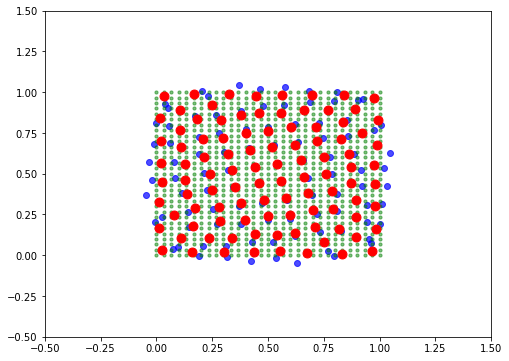

In [88]:
# Set up the figure and axis for animation
fig, ax = plt.subplots(figsize=(8, 6))
scat_G = ax.scatter(G[:, 0].cpu(), G[:, 1].cpu(), color='blue', label='G_i', alpha=0.7)
scat_Y = ax.scatter(Y[:, 0].cpu(), Y[:, 1].cpu(), color='green', s=5, label='Y_j', alpha=0.5)
scat_X = ax.scatter(X[:, 0].detach().cpu(), X[:, 1].detach().cpu(), color='red', marker='x', s=80)

# Initialize the plot labels
ax.legend()
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')

# Update function for animation
def anim_function(i):
    global X, G
    
    ax.cla()
    ax.set(xlim=[-0.5, 1.5], ylim=[-0.5, 1.5])

    
    # Update X and G
    X = x_adaptation(G, X, Y, sigma=sigma, loss=loss, tol=1e-4)
    G = g_speed(G, X, dt, J)
    X = x_guess(G, X, dt, J)
    
    # Update scatter plot data without clearing the figure
    scat_G = ax.scatter(G[:, 0].cpu(), G[:, 1].cpu(), color='blue', label='G_i', alpha=0.7)
    scat_Y = ax.scatter(Y[:, 0].cpu(), Y[:, 1].cpu(), color='green', s=10, label='Y_j', alpha=0.5)
    scat_X = ax.scatter(X[:, 0].detach().cpu(), X[:, 1].detach().cpu(), color='red', s=80)

    return scat_G, scat_X

# Create the animation
num_frames = int(T/dt)  # Number of frames for the GIF
anim = FuncAnimation(fig, anim_function, frames=num_frames, interval=300, blit=True)

# Save animation directly as a GIF using PillowWriter
anim.save('dense_true.gif')#, writer=PillowWriter(fps=3))  # Adjust fps as needed


# Jet testing 1d embdding in two  D

In [ ]:
dt = 0.1
T = 1
N = 100
M = 5*N 

loss = SamplesLoss('sinkhorn', p=2, blur=1/np.sqrt(N), scaling=0.9)
lr = 0.5
sigma = 1 / N**2

X, Y, G, swsg_class, h_true = initialisation(
    epsilon=1 / np.sqrt(N), d=1.0, profile_type='jet', cuda=0
)

G = G.to('cuda:0')
X = X.to('cuda:0').requires_grad_(True)
Y = Y.to('cuda:0')
J = -1*torch.Tensor([[0, 1], [-1, 0 ]]).type_as(G)

0 tensor(0.035648528339005, device='cuda:0')
1 tensor(0.020437817327698, device='cuda:0')
2 tensor(0.011738668815819, device='cuda:0')
3 tensor(0.006753397015536, device='cuda:0')
4 tensor(0.003890540738746, device='cuda:0')
5 tensor(0.002243039465455, device='cuda:0')
6 tensor(0.001292913988022, device='cuda:0')
7 tensor(0.000743821745030, device='cuda:0')
8 tensor(0.000425905235661, device='cuda:0')
9 tensor(0.000241594723427, device='cuda:0')
10 tensor(0.000161338727957, device='cuda:0')
11 tensor(0.000115254306100, device='cuda:0')
12 tensor(8.381165743783524e-05, device='cuda:0')
13 tensor(6.863060087176705e-05, device='cuda:0')
14 tensor(5.739208816064171e-05, device='cuda:0')
15 tensor(4.881665507878023e-05, device='cuda:0')
16 tensor(4.209189894778283e-05, device='cuda:0')
17 tensor(3.669065869678301e-05, device='cuda:0')
18 tensor(3.226284294325183e-05, device='cuda:0')
19 tensor(2.857024491938814e-05, device='cuda:0')
20 tensor(2.544671041140854e-05, device='cuda:0')
21 tenso

MovieWriter ffmpeg unavailable; using Pillow instead.


0 tensor(0.007579048424263, device='cuda:0')
1 tensor(0.004237789567576, device='cuda:0')
2 tensor(0.002397177244116, device='cuda:0')
3 tensor(0.001427931907077, device='cuda:0')
4 tensor(0.000927346097079, device='cuda:0')
5 tensor(0.000630494699415, device='cuda:0')
6 tensor(0.000449704690352, device='cuda:0')
7 tensor(0.000336117380889, device='cuda:0')
8 tensor(0.000262212139449, device='cuda:0')
9 tensor(0.000212286110871, device='cuda:0')
10 tensor(0.000177240581672, device='cuda:0')
11 tensor(0.000151707238437, device='cuda:0')
12 tensor(0.000132451703679, device='cuda:0')
13 tensor(0.000117478426170, device='cuda:0')
14 tensor(0.000105523397525, device='cuda:0')
15 tensor(9.576307618794077e-05, device='cuda:0')
16 tensor(8.764497450740929e-05, device='cuda:0')
17 tensor(8.078744199674474e-05, device='cuda:0')
18 tensor(7.491928583490236e-05, device='cuda:0')
19 tensor(6.984264545914369e-05, device='cuda:0')
20 tensor(6.540965463524088e-05, device='cuda:0')
21 tensor(6.15074218

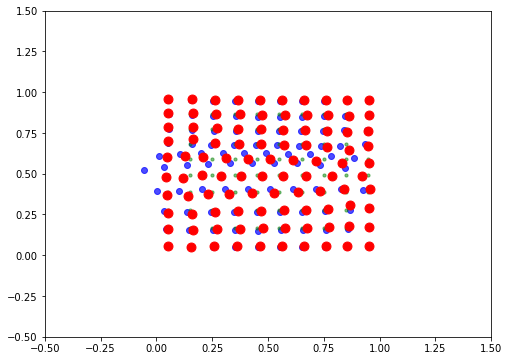

In [94]:
# Set up the figure and axis for animation
fig, ax = plt.subplots(figsize=(8, 6))
scat_G = ax.scatter(G[:, 0].cpu(), G[:, 1].cpu(), color='blue', label='G_i', alpha=0.7)
scat_Y = ax.scatter(Y[:, 0].cpu(), Y[:, 1].cpu(), color='green', s=5, label='Y_j', alpha=0.5)
scat_X = ax.scatter(X[:, 0].detach().cpu(), X[:, 1].detach().cpu(), color='red', marker='x', s=80)

# Initialize the plot labels
ax.legend()
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')

# Update function for animation
def anim_function(i):
    global X, G
    
    ax.cla()
    ax.set(xlim=[-0.5, 1.5], ylim=[-0.5, 1.5])

    
    # Update X and G
    X = x_adaptation(G, X, Y, sigma=sigma, loss=loss, tol=1e-5)
    G = g_speed(G, X, dt, J)
    X = x_guess(G, X, dt, J)
    
    # Update scatter plot data without clearing the figure
    scat_G = ax.scatter(G[:, 0].cpu(), G[:, 1].cpu(), color='blue', label='G_i', alpha=0.7)
    scat_Y = ax.scatter(Y[:, 0].cpu(), Y[:, 1].cpu(), color='green', s=10, label='Y_j', alpha=0.5)
    scat_X = ax.scatter(X[:, 0].detach().cpu(), X[:, 1].detach().cpu(), color='red', s=80)

    return scat_G, scat_X

# Create the animation
num_frames = int(T/dt)  # Number of frames for the GIF
anim = FuncAnimation(fig, anim_function, frames=num_frames, interval=300, blit=True)

# Save animation directly as a GIF using PillowWriter
anim.save('animation_jet.gif')#, writer=PillowWriter(fps=3))  # Adjust fps as needed


In [95]:
## Jet Done on a annulus

In [ ]:
def dense_uniform_annulus(R_inner, R_outer, num_radial_points):
    # Radial distances spaced by square root to maintain uniform density
    r = np.linspace(np.sqrt(R_inner), np.sqrt(R_outer), num_radial_points)**2

    x_points = []
    y_points = []
    
    for radius in r:
        # Determine the number of points at this radius
        num_points_at_radius = int(2 * np.pi * radius / (R_outer - R_inner) * num_radial_points)

        # Angular positions for these points
        angles = np.linspace(0, 2 * np.pi, num_points_at_radius, endpoint=False)

        # Convert polar coordinates to Cartesian
        x_points.extend(radius * np.cos(angles))
        y_points.extend(radius * np.sin(angles))

    # Stack x and y points into a single array for easy plotting
    return np.stack([np.array(x_points), np.array(y_points)], axis=-1)

In [142]:
Y = dense_uniform_annulus(0.6, 1, 20)
Y.shape

(4969, 2)

In [143]:
def generate_uniform_annulus(R_inner, R_outer, num_radial_points):
    # Radial distances spaced by square root to maintain uniform density
    r = np.linspace(np.sqrt(R_inner), np.sqrt(R_outer), num_radial_points)**2

    x_points = []
    y_points = []
    gx_points = []
    gy_points = []
    height = []
    f=1.0
    g=0.1
    a,b,c = 0.1, 10, (R_outer + R_inner) / 2
    d=1
    # Define jet height function
    def jet_h(r):
        return a * np.tanh(b * (r - c)) + d
    
    for radius in r:
        # Determine the number of points at this radius
        num_points_at_radius = int(2 * np.pi * radius / (R_outer - R_inner) * num_radial_points)

        # Angular positions for these points
        angles = np.linspace(0, 2 * np.pi, num_points_at_radius, endpoint=False)

        # Convert polar coordinates to Cartesian
        x_points.extend(radius * np.cos(angles))
        y_points.extend(radius * np.sin(angles))
        
        # Calculate height for each point at this radius
        height.extend([jet_h(radius)] * num_points_at_radius)
        G_i = radius + f**2 * g * a * b * (1 - np.tanh(b * (radius - c)) ** 2)
        gx_points.extend(G_i * np.cos(angles))
        gy_points.extend(G_i * np.sin(angles))

    # Stack x and y points into a single array for easy plotting
    return np.stack([np.array(x_points), np.array(y_points)], axis=-1), height,np.stack([np.array(gx_points), np.array(gy_points)], axis=-1)

# Parameters
R_inner = 0.6       # Inner radius of the annulus
R_outer = 1       # Outer radius of the annulus
num_radial_points = 9   # Number of radial steps

# Generate uniformly spaced annulus points
xy, h, Gxy = generate_uniform_annulus(R_inner, R_outer, num_radial_points)


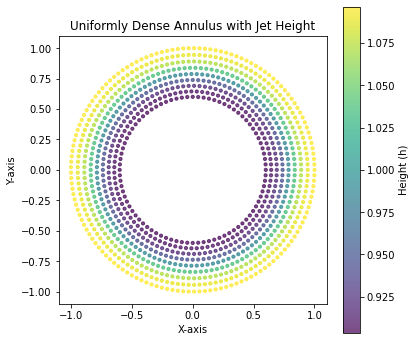

In [129]:
# Plot the annulus
plt.figure(figsize=(6, 6))
p = plt.scatter(xy[:, 0], xy[:, 1], c=h, s=10, alpha=0.7, cmap='viridis')
plt.colorbar(p, label="Height (h)")
plt.gca().set_aspect('equal', adjustable='box')
plt.title("Uniformly Dense Annulus with Jet Height")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.show()


In [159]:
dt = 0.1
T = 5

loss = SamplesLoss('sinkhorn', p=2, blur=1/np.sqrt(N), scaling=0.9)
lr = 0.5
sigma = 0.0001

G = torch.Tensor(Gxy).to('cuda:0')
X = torch.Tensor(xy).to('cuda:0').requires_grad_(True)
Y = torch.Tensor(Y).to('cuda:0')
J = -1*torch.Tensor([[0, 1], [-1, 0 ]]).type_as(G)

In [155]:
G.shape, Y.shape

(torch.Size([1004, 2]), torch.Size([4969, 2]))

1 tensor(0.001729762933717, device='cuda:0')


MovieWriter ffmpeg unavailable; using Pillow instead.


1 tensor(0.001630889160477, device='cuda:0')
1 tensor(0.001535775378206, device='cuda:0')
1 tensor(0.001444234679950, device='cuda:0')
1 tensor(0.001356095618181, device='cuda:0')
1 tensor(0.001271200743653, device='cuda:0')
1 tensor(0.001189405367441, device='cuda:0')
1 tensor(0.001110576538724, device='cuda:0')
1 tensor(0.001034592232130, device='cuda:0')
1 tensor(0.000961340740243, device='cuda:0')
1 tensor(0.000890720268873, device='cuda:0')
1 tensor(0.000822643604140, device='cuda:0')
1 tensor(0.000781661534693, device='cuda:0')
1 tensor(0.000759367163823, device='cuda:0')
1 tensor(0.000738522520998, device='cuda:0')
1 tensor(0.000719169441117, device='cuda:0')
1 tensor(0.000701350168960, device='cuda:0')
1 tensor(0.000685104610991, device='cuda:0')
1 tensor(0.000670467530322, device='cuda:0')
1 tensor(0.000657465738759, device='cuda:0')
1 tensor(0.000646115345587, device='cuda:0')
1 tensor(0.000724824539817, device='cuda:0')
1 tensor(0.000878632691649, device='cuda:0')
1 tensor(0

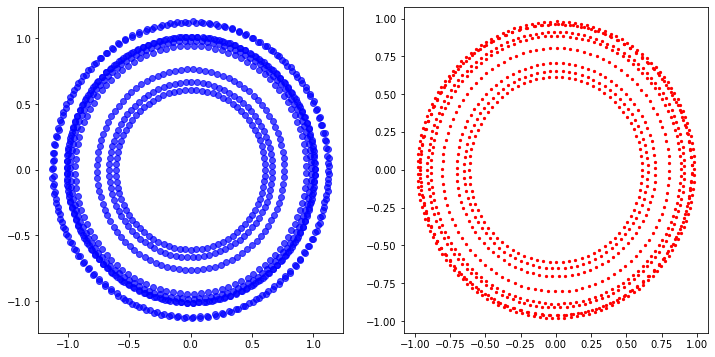

In [160]:
# Set up the figure and axis for animation
fig = plt.figure(figsize=(12, 6))

ax = fig.add_subplot(121)
ax1 = fig.add_subplot(122)

scat_G = ax.scatter(G[:, 0].cpu(), G[:, 1].cpu(), color='blue', label='G_i', alpha=0.7)
scat_Y = ax.scatter(Y[:, 0].cpu(), Y[:, 1].cpu(), color='green', s=5, label='Y_j', alpha=0.5)
scat_X = ax.scatter(X[:, 0].detach().cpu(), X[:, 1].detach().cpu(), color='red', marker='x', s=80)

# Initialize the plot labels
ax.legend()
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')

# Update function for animation
def anim_function(i):
    global X, G
    
    ax.cla()
    ax1.cla()
    # ax.set(xlim=[-0.5, 1.5], ylim=[-0.5, 1.5])
    
    # Update X and G
    X = x_adaptation(G, X, Y, sigma=sigma, loss=loss, tol=1e-1)
    G = g_speed(G, X, dt, J)
    X = x_guess(G, X, dt, J)
    
    # Update scatter plot data without clearing the figure
    scat_G = ax.scatter(G[:, 0].cpu(), G[:, 1].cpu(), color='blue', label='G_i', alpha=0.7)
    # scat_Y = ax.scatter(Y[:, 0].cpu(), Y[:, 1].cpu(), color='green', s=5, label='Y_j', alpha=0.5)
    scat_X = ax1.scatter(X[:, 0].detach().cpu(), X[:, 1].detach().cpu(), color='red', s=5)

    return scat_G, scat_X

# Create the animation
num_frames = int(T/dt)  # Number of frames for the GIF
anim = FuncAnimation(fig, anim_function, frames=num_frames, interval=300, blit=True)

# Save animation directly as a GIF using PillowWriter
anim.save('disc_jet_1.gif')#, writer=PillowWriter(fps=3))  # Adjust fps as needed
